In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout,Reshape
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Function to load images from the given directory, filtered by allowed labels
def load_images(directory, allowed_labels=None):
    images = []
    labels = []
    uniq_labels = sorted(os.listdir(directory))

    for label in uniq_labels:
        if allowed_labels is None or label in allowed_labels:
            label_dir = os.path.join(directory, label)
            for file in os.listdir(label_dir):
                filepath = os.path.join(label_dir, file)
                image = cv2.imread(filepath)
                if image is not None:
                    image = cv2.resize(image, (64, 64))
                    images.append(image)
                    labels.append(label)
                else:
                    print(f"Warning: Unable to load image at {filepath}")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, uniq_labels

# Directory containing the datasets
asl_data_dir = "/content/drive/MyDrive/DL/asl_dataset"
isl_data_dir = "/content/drive/MyDrive/DL/isl_dataset"

# Load images and labels for ASL dataset
asl_images, asl_labels, asl_uniq_labels = load_images(asl_data_dir)

# Load images and labels for ISL dataset
isl_images, isl_labels, isl_uniq_labels = load_images(isl_data_dir)

# Determine unique and common labels between ASL and ISL datasets
asl_labels_set = set(asl_uniq_labels)
isl_labels_set = set(isl_uniq_labels)
common_labels = asl_labels_set.intersection(isl_labels_set)
asl_only_labels = asl_labels_set - isl_labels_set
isl_only_labels = isl_labels_set - asl_labels_set

# Filter and combine images and labels
combined_images = []
combined_labels = []

# Add ASL-only images and labels
asl_filtered_images, asl_filtered_labels, _ = load_images(asl_data_dir, allowed_labels=asl_only_labels)
combined_images.extend(asl_filtered_images)
combined_labels.extend(asl_filtered_labels)

# Add ISL-only images and labels
isl_filtered_images, isl_filtered_labels, _ = load_images(isl_data_dir, allowed_labels=isl_only_labels)
combined_images.extend(isl_filtered_images)
combined_labels.extend(isl_filtered_labels)

# Add common label images and labels
asl_common_images, asl_common_labels, _ = load_images(asl_data_dir, allowed_labels=common_labels)
isl_common_images, isl_common_labels, _ = load_images(isl_data_dir, allowed_labels=common_labels)

combined_images.extend(asl_common_images)
combined_labels.extend(asl_common_labels)
combined_images.extend(isl_common_images)
combined_labels.extend(isl_common_labels)

# Convert combined data to numpy arrays
combined_images = np.array(combined_images)
combined_labels = np.array(combined_labels)

# Convert labels to numeric indices based on the combined unique labels
unique_labels = sorted(asl_labels_set.union(isl_labels_set))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
combined_labels_numeric = np.array([label_to_index[label] for label in combined_labels])

# Ensure labels are in one-hot encoding format
labels_one_hot = to_categorical(combined_labels_numeric, num_classes=len(unique_labels))

# Split the combined dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_images, labels_one_hot, test_size=0.2, stratify=combined_labels_numeric, random_state=42)

# Example print to check shapes of the datasets
print("Combined data shape:", combined_images.shape, combined_labels_numeric.shape)
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Combined data shape: (9125, 64, 64, 3) (9125,)
Training data shape: (7300, 64, 64, 3) (7300, 36)
Testing data shape: (1825, 64, 64, 3) (1825, 36)


In [ ]:
y_train = to_categorical(y_train, num_classes=len(asl_uniq_labels))
y_test = to_categorical(y_test, num_classes=len(asl_uniq_labels))

# Normalize the images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0



In [ ]:
classifier_vgg16 = VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
for layer in classifier_vgg16.layers:
    layer.trainable = False


In [ ]:
classifier1 = Flatten()(classifier_vgg16.output)
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=len(asl_uniq_labels), activation='softmax')(classifier1)

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [ ]:
model_vgg16 = Model(inputs=classifier_vgg16.input, outputs=classifier1)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
classifier_resnet = ResNet50(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
for layer in classifier_resnet.layers:
    layer.trainable = False

classifier2 = Flatten()(classifier_resnet.output)
classifier2 = Dense(units=256, activation='relu')(classifier2)
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=len(unique_labels), activation='softmax')(classifier2)


In [ ]:
# ResNet50 model
classifier_resnet = ResNet50(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
for layer in classifier_resnet.layers:
    layer.trainable = False

classifier2 = Flatten()(classifier_resnet.output)
classifier2 = Dense(units=256, activation='relu')(classifier2)
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=len(unique_labels), activation='softmax')(classifier2)

model_resnet = Model(inputs=classifier_resnet.input, outputs=classifier2)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_resnet = Model(inputs=classifier_resnet.input, outputs=classifier2)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_vgg16 = model_vgg16.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))



Epoch 1/5
115/115 [==============================] - 398s 3s/step - loss: 0.3148 - accuracy: 0.8992 - val_loss: 0.0985 - val_accuracy: 0.9704
Epoch 2/5
115/115 [==============================] - 393s 3s/step - loss: 0.3062 - accuracy: 0.9036 - val_loss: 0.1479 - val_accuracy: 0.9578
Epoch 3/5
115/115 [==============================] - 398s 3s/step - loss: 0.2747 - accuracy: 0.9130 - val_loss: 0.0888 - val_accuracy: 0.9704
Epoch 4/5
115/115 [==============================] - 398s 3s/step - loss: 0.2627 - accuracy: 0.9116 - val_loss: 0.1024 - val_accuracy: 0.9671
Epoch 5/5
115/115 [==============================] - 395s 3s/step - loss: 0.2471 - accuracy: 0.9203 - val_loss: 0.0914 - val_accuracy: 0.9770


In [ ]:
history_resnet = model_resnet.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
115/115 [==============================] - 142s 1s/step - loss: 1.8929 - accuracy: 0.5285 - val_loss: 0.7223 - val_accuracy: 0.8049
Epoch 2/5
115/115 [==============================] - 142s 1s/step - loss: 0.9844 - accuracy: 0.6992 - val_loss: 0.4633 - val_accuracy: 0.8729
Epoch 3/5
115/115 [==============================] - 139s 1s/step - loss: 0.8171 - accuracy: 0.7459 - val_loss: 0.4200 - val_accuracy: 0.8827
Epoch 4/5
115/115 [==============================] - 121s 1s/step - loss: 0.7258 - accuracy: 0.7677 - val_loss: 0.3610 - val_accuracy: 0.8893
Epoch 5/5
115/115 [==============================] - 138s 1s/step - loss: 0.6576 - accuracy: 0.7848 - val_loss: 0.2655 - val_accuracy: 0.9189


In [ ]:
model_vgg16.save('model_vgg16.h5')
model_resnet.save('model_resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
score_vgg16 = model_vgg16.evaluate(X_test, y_test, verbose=0)
score_resnet = model_resnet.evaluate(X_test, y_test, verbose=0)

In [ ]:

print('VGG16 Accuracy for test images:', round(score_vgg16[1] * 100, 3), '%')
print('ResNet50 Accuracy for test images:', round(score_resnet[1] * 100, 3), '%')

VGG16 Accuracy for test images: 97.699 %
ResNet50 Accuracy for test images: 91.89 %


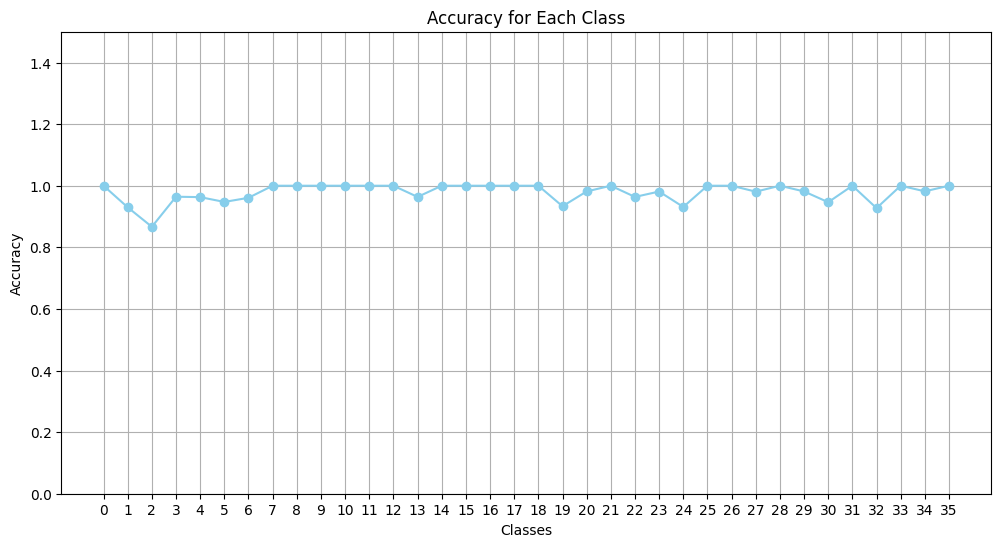

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true and predicted labels respectively
report = classification_report(y_true, y_pred_classes, output_dict=True)

# Extract accuracy for each class
class_accuracy = {key: value['precision'] for key, value in report.items() if key.isdigit()}

# Plot line plot
classes = list(class_accuracy.keys())
accuracies = list(class_accuracy.values())

plt.figure(figsize=(12, 6))
plt.plot(classes, accuracies, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim(0, 1.5)  # Accuracy ranges from 0 to 1
plt.grid(True)
plt.show()


<ipython-input-77-7ae69e646cc4>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo-', label='Training loss', color='skyblue')
<ipython-input-77-7ae69e646cc4>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'ro-', label='Validation loss', color='orange')


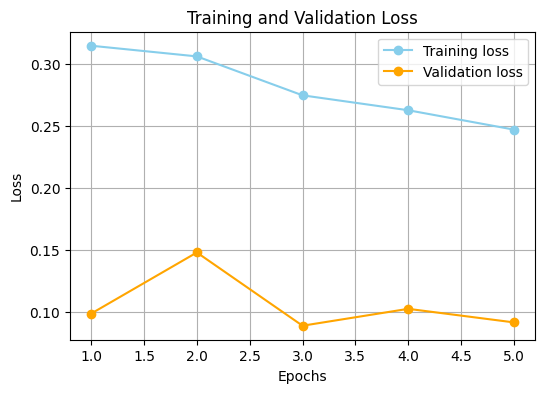

In [ ]:
import matplotlib.pyplot as plt

# Assuming history_vgg16 contains loss values for each epoch
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, 'bo-', label='Training loss', color='skyblue')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


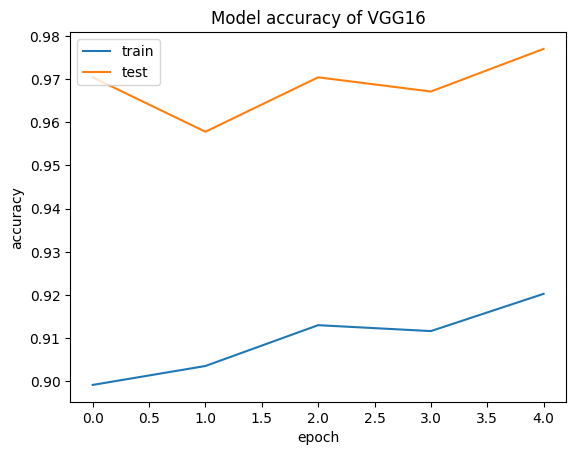

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

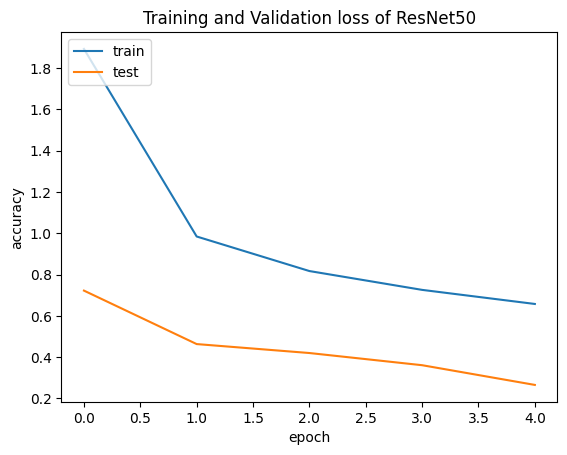

In [ ]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Training and Validation loss of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report

# Assuming X_train, X_test, y_train, y_test are already defined from your dataset

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))  # Assuming input image size is 64x64 pixels with 3 channels (RGB)
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(len(unique_labels), activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test back to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=unique_labels))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 128)        

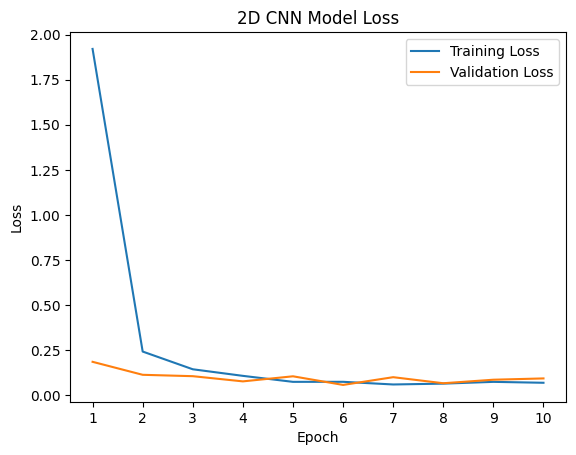

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('2D CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(10), range(1, 11))
plt.legend()
plt.show()

In [ ]:
from keras.models import Model, Sequential
feature_extractor = VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
for layer in feature_extractor.layers:
    layer.trainable = False

# Create a model for feature extraction
input_shape = (64, 64, 3)
feature_model = Sequential([
    feature_extractor,
    Flatten()
])

In [ ]:
X_train_features = feature_model.predict(X_train)
X_test_features = feature_model.predict(X_test)


58/58 [==============================] - 79s 1s/step


In [ ]:
time_steps = 1  # You can modify this based on your requirement
X_train_features = X_train_features.reshape((X_train_features.shape[0], time_steps, X_train_features.shape[1]))
X_test_features = X_test_features.reshape((X_test_features.shape[0], time_steps, X_test_features.shape[1]))


In [ ]:
from keras.layers import Flatten, Dense, Dropout, LSTM, TimeDistributed
from keras.utils import to_categorical
import matplotlib.pyplot as plt
model = Sequential()
model.add(LSTM(256, input_shape=(time_steps, X_train_features.shape[2]), return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train_features, y_train, epochs=20, batch_size=64, validation_data=(X_test_features, y_test))


Epoch 1/20
115/115 [==============================] - 9s 52ms/step - loss: 1.5108 - accuracy: 0.6544 - val_loss: 0.6778 - val_accuracy: 0.8685
Epoch 2/20
115/115 [==============================] - 4s 38ms/step - loss: 0.6567 - accuracy: 0.8366 - val_loss: 0.4304 - val_accuracy: 0.9321
Epoch 3/20
115/115 [==============================] - 5s 46ms/step - loss: 0.4517 - accuracy: 0.8825 - val_loss: 0.3226 - val_accuracy: 0.9315
Epoch 4/20
115/115 [==============================] - 5s 46ms/step - loss: 0.3689 - accuracy: 0.9056 - val_loss: 0.2503 - val_accuracy: 0.9479
Epoch 5/20
115/115 [==============================] - 4s 38ms/step - loss: 0.3198 - accuracy: 0.9141 - val_loss: 0.2365 - val_accuracy: 0.9452
Epoch 6/20
115/115 [==============================] - 5s 45ms/step - loss: 0.2875 - accuracy: 0.9221 - val_loss: 0.1984 - val_accuracy: 0.9584
Epoch 7/20
115/115 [==============================] - 6s 48ms/step - loss: 0.2458 - accuracy: 0.9333 - val_loss: 0.1728 - val_accuracy: 0.9567

In [ ]:
model.save('model_lstm.h5')

# Evaluate the model
score = model.evaluate(X_test_features, y_test, verbose=0)
print('LSTM Accuracy for test images:', round(score[1] * 100, 3), '%')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


LSTM Accuracy for test images: 97.973 %


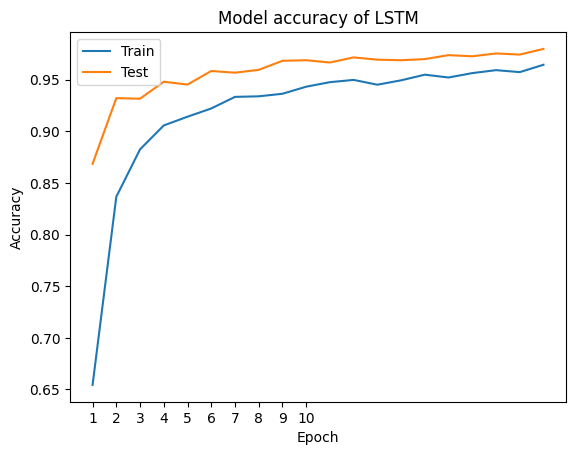

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` contains the training history of your model

# Plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy of LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Setting x-axis ticks to range from 1 to 10
plt.xticks(range(10), range(1, 11))

plt.show()
